# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.preprocessing.sequence import pad_sequences
from catboost import CatBoostClassifier

# Load and view the Data

In [3]:
# Read the CSV file
df = pd.read_csv('Resources\\train.csv',encoding='ISO-8859-1')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [5]:
df

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26
...,...,...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,night,31-45,Ghana,31072940,227540.0,137
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,morning,46-60,Greece,10423054,128900.0,81
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,noon,60-70,Grenada,112523,340.0,331
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,night,70-100,Guatemala,17915568,107160.0,167


## Data Cleaning
Cleaning out any empty values, setting everything to a string, and encoding the sentiment column as numeric

In [6]:
# Initialize the encoder
encoder = LabelEncoder()

# Fit the encoder and transform the labels to numerical (not categorical)
df['sentiment'] = encoder.fit_transform(df['sentiment'])

# encoding key:
# 0 = negative
# 1 = neutral
# 2 = positive

In [7]:
# Clean up any empty values and ensure everything is a string

# Fill None values with empty strings
df['selected_text'] = df['selected_text'].fillna('')
df['text'] = df['text'].fillna('')

# Ensure all entries are strings
df['selected_text'] = df['selected_text'].astype(str)
df['text'] = df['text'].fillna('')

# Tokenization
We need the text of the tweets to be tokenized before we can use them to train any sort of model

In [8]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [9]:
# Test longest tweet to see number of tokens based on tokenizer. 
tokens = tokenizer.tokenize("Ahhh, I slept through the game. I`m gonna try my best to watch tomorrow though. I hope we play Army...")
print(len(tokens))

29


In [10]:
# Tokenize the tweets
df['tokens'] = df['selected_text'].apply(lambda x: tokenizer.encode(x, truncation=True, max_length=128))

In [11]:
# check it again
df

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),tokens
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",1,morning,0-20,Afghanistan,38928346,652860.0,60,"[101, 1045, 1036, 1040, 2031, 5838, 1010, 2065..."
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0,noon,21-30,Albania,2877797,27400.0,105,"[101, 17111, 2080, 6517, 102]"
2,088c60f138,my boss is bullying me...,bullying me,0,night,31-45,Algeria,43851044,2381740.0,18,"[101, 18917, 2033, 102]"
3,9642c003ef,what interview! leave me alone,leave me alone,0,morning,46-60,Andorra,77265,470.0,164,"[101, 2681, 2033, 2894, 102]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0,noon,60-70,Angola,32866272,1246700.0,26,"[101, 4124, 1997, 1008, 1008, 1008, 1008, 1010..."
...,...,...,...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,0,night,31-45,Ghana,31072940,227540.0,137,"[101, 1040, 2439, 102]"
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",0,morning,46-60,Greece,10423054,128900.0,81,"[101, 1010, 2123, 1036, 1056, 2486, 102]"
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,2,noon,60-70,Grenada,112523,340.0,331,"[101, 8038, 2100, 2204, 2005, 2119, 1997, 2017..."
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,2,night,70-100,Guatemala,17915568,107160.0,167,"[101, 2021, 2009, 2001, 4276, 2009, 1008, 1008..."


# Padding
The tokenized text in the tokens column is not all the same length. We need to fix that before we can use it.

In [12]:
# Get the length of the longest sequence
max_len = df['tokens'].str.len().max()
print(max_len)

110


In [13]:
# Pad the sequences
df['tokens'] = pad_sequences(df['tokens'], maxlen=max_len, padding='post', value=0).tolist()

In [14]:
# check it once more
df

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),tokens
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",1,morning,0-20,Afghanistan,38928346,652860.0,60,"[101, 1045, 1036, 1040, 2031, 5838, 1010, 2065..."
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0,noon,21-30,Albania,2877797,27400.0,105,"[101, 17111, 2080, 6517, 102, 0, 0, 0, 0, 0, 0..."
2,088c60f138,my boss is bullying me...,bullying me,0,night,31-45,Algeria,43851044,2381740.0,18,"[101, 18917, 2033, 102, 0, 0, 0, 0, 0, 0, 0, 0..."
3,9642c003ef,what interview! leave me alone,leave me alone,0,morning,46-60,Andorra,77265,470.0,164,"[101, 2681, 2033, 2894, 102, 0, 0, 0, 0, 0, 0,..."
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0,noon,60-70,Angola,32866272,1246700.0,26,"[101, 4124, 1997, 1008, 1008, 1008, 1008, 1010..."
...,...,...,...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,0,night,31-45,Ghana,31072940,227540.0,137,"[101, 1040, 2439, 102, 0, 0, 0, 0, 0, 0, 0, 0,..."
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",0,morning,46-60,Greece,10423054,128900.0,81,"[101, 1010, 2123, 1036, 1056, 2486, 102, 0, 0,..."
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,2,noon,60-70,Grenada,112523,340.0,331,"[101, 8038, 2100, 2204, 2005, 2119, 1997, 2017..."
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,2,night,70-100,Guatemala,17915568,107160.0,167,"[101, 2021, 2009, 2001, 4276, 2009, 1008, 1008..."


# Vectorization

In [15]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the tokens
X = vectorizer.fit_transform(df['tokens'].apply(lambda x: ' '.join(map(str, x))))
# define y while we're at it
y = df['sentiment']

# Splitting Test/Train

In [16]:
# Split the data into training and test sets (deja vu)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Convert sparse matrix to dense matrix
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Scaling
This apparently was not needed but was kept in just in case.

In [18]:
#scaler = MinMaxScaler()
#X_train_scaled = scaler.fit(X_train)
#X_test_scaled = scaler.fit(X_test)

# KNN n_neighbors selection

c:\Users\rac06\anaconda3\envs\proj3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rac06\anaconda3\envs\proj3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rac06\anaconda3\envs\proj3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rac06\anaconda3\envs\proj3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will chang

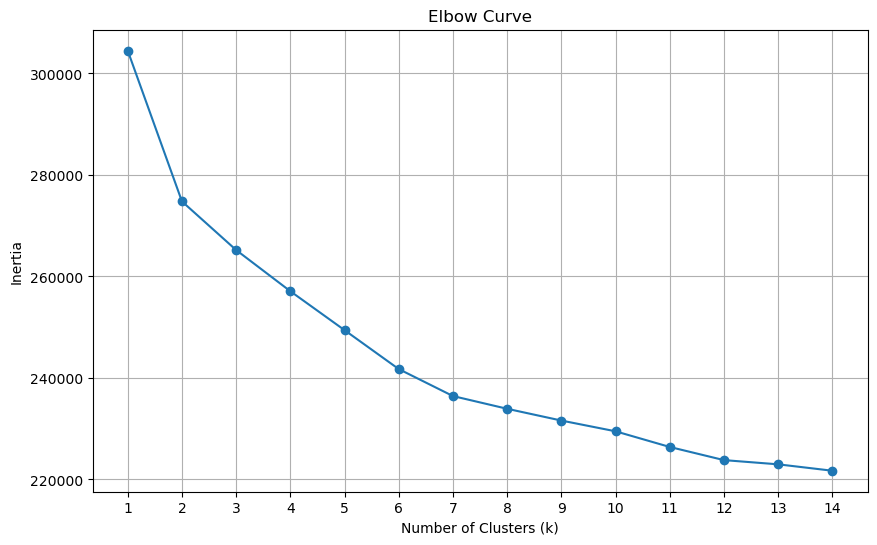

In [19]:
# Range of k values to try
k_values = range(1, 15)

# List to store the inertia for each k value
inertia = []

# Compute inertia for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_dense)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Model selection Pipeline

In [21]:
# From Ray and Omar's Group Project 2
classifiers = [
    ('KNN', KNeighborsClassifier(n_neighbors=7)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('SVM', SVC(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('CatBoost', CatBoostClassifier(silent=True, random_state=42))
]

# Initialize a list to store the results
results = []

# Iterate over the classifiers, train them on the processed training set, and evaluate on the processed test set
for name, classifier in classifiers:
    # Train the model using the processed training sets
    classifier.fit(X_train_dense, y_train)
    
    # Predict the response for the processed test dataset
    y_pred = classifier.predict(X_test_dense)
    
    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # Append the results
    results.append((name, accuracy, precision, recall, f1))

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1'])

# Sort the DataFrame by Accuracy score in descending order
results_df_sorted = results_df.sort_values(by='Accuracy', ascending=False)

# Display the sorted DataFrame
results_df_sorted

,Classifier,Accuracy,Precision,Recall,F1
2,Logistic Regression,0.835547,0.834354,0.838142,0.836042
3,SVM,0.831908,0.838552,0.826290,0.830144
1,Random Forest,0.817901,0.829613,0.807835,0.815331
8,CatBoost,0.806258,0.806793,0.802979,0.804124
4,Gradient Boosting,0.754411,0.761935,0.746378,0.748300
5,Decision Tree,0.750955,0.753152,0.747617,0.750038
6,AdaBoost,0.701837,0.715016,0.698007,0.696478
0,KNN,0.637257,0.682029,0.672993,0.625186
7,Naive Bayes,0.586502,0.611019,0.583419,0.563991


# Saving the best model

In [22]:
from joblib import dump

# Select the best model
best_classifier_name = results_df_sorted.iloc[0]['Classifier']

# Find the trained classifier object
best_classifier = None
for name, classifier in classifiers:
    if name == best_classifier_name:
        best_classifier = classifier
        break

# Save the best model
dump(best_classifier, 'model_directory\\sentiment_model.pk1')

['model_directory\\sentiment_model.pk1']